In [ ]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset
from skimage.color import rgb2lab
from torch import nn
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import random_split
import torch.optim as optim
from torchvision import models

In [ ]:
# -----------------------
# Blocs utilitaires
# -----------------------
def conv_block(in_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
    )

class UNetEncoder(nn.Module):
    """
    Retourne 3 niveaux de features (f1,f2,f3) de résolutions décroissantes.
    """
    def __init__(self, base=32):
        super().__init__()
        self.enc1 = conv_block(1, base)           # input: luminance 1ch
        self.pool = nn.MaxPool2d(2)
        self.enc2 = conv_block(base, base*2)
        self.enc3 = conv_block(base*2, base*4)

    def forward(self, x):
        f1 = self.enc1(x)         # HxW
        f2 = self.enc2(self.pool(f1))  # H/2 x W/2
        f3 = self.enc3(self.pool(f2))  # H/4 x W/4
        return f1, f2, f3

class UNetDecoder(nn.Module):
    """
    Decoder qui prend listes de skip features et color_features injectées aux 3 niveaux.
    skip_feats: [f1,f2,f3], color_feats: [c1,c2,c3]
    """
    def __init__(self, base=32):
        super().__init__()
        # Niveau 3
        self.up3 = nn.ConvTranspose2d(base*4 + 256, base*2, 2, 2)
        self.dec3 = conv_block(base*2 + base*2 + 128, base*2)

        # Niveau 2
        self.up2 = nn.ConvTranspose2d(base*2, base, 2, 2)
        self.dec2 = conv_block(base + base + 64, base)

        self.final_conv = nn.Conv2d(base, 2, 1)

    def forward(self, f_skips, color_feats):
        f1, f2, f3 = f_skips
        c1, c2, c3 = color_feats

        # bottleneck: f3 is deepest
        x = f3
        c3_up = F.interpolate(c3, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([f3, c3_up], dim=1)

        x = self.up3(x)  # up to size of f2
        # concat with f2 and color-feat c3 (upsampled)
        c2_up = F.interpolate(c2, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, f2, c2_up], dim=1)
        x = self.dec3(x)

        x = self.up2(x)  # up to size of f1
        c1_up = F.interpolate(c1, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, f1, c1_up], dim=1)
        x = self.dec2(x)

        ab = torch.tanh(self.final_conv(x))  # ab in [-1,1]
        return ab

# -----------------------
# VGG19 feature extractor (gelé)
# -----------------------
class VGG19FeatExtractor(nn.Module):
    """
    Extrait 3 niveaux de features depuis VGG19 pré-entraîné.
    On choisit des points d'extraction raisonnables.
    Input: RGB
    Retour: trois feature maps (phi1,phi2,phi3)
    """
    def __init__(self, pretrained=True):
        super().__init__()
        vgg19 = models.vgg19(pretrained=pretrained).features
        # relu1_2 -> layer 3, relu2_2 -> layer 8, relu3_4 -> layer 17 (valeurs usuelles)
        self.slice1 = nn.Sequential(*[vgg19[i] for i in range(0, 4)])   # up to relu1_2
        self.slice2 = nn.Sequential(*[vgg19[i] for i in range(4, 9)])   # up to relu2_2
        self.slice3 = nn.Sequential(*[vgg19[i] for i in range(9, 18)])  # up to relu3_4
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):
        p1 = self.slice1(x)
        p2 = self.slice2(p1)
        p3 = self.slice3(p2)
        return p1, p2, p3

# -----------------------
# Attention block (grid-based)
# -----------------------
class AttentionBlock(nn.Module):
    """
    Approximation pratique des pixels par un downsample grid (sx x sx).
    Inputs:
      fT: target luminance features (B,C,H,W)
      fR: reference luminance features (B,C,H,W)
      phiR: reference color features (B,Cphi,H_r,W_r)
    Output:
      color features transferred (B, Cphi, H_out, W_out)
    """
    def __init__(self, grid_size=8, temperature=0.05):
        super().__init__()
        self.grid_size = grid_size
        self.tau = temperature

    def forward(self, fT, fR, phiR):
        # fT, fR: BxC x H x W
        B, C, H, W = fT.shape

        # build features by adaptive avg pool to grid_size x grid_size
        FT = F.adaptive_avg_pool2d(fT, output_size=(self.grid_size, self.grid_size))  # BxC x s s
        FR = F.adaptive_avg_pool2d(fR, output_size=(self.grid_size, self.grid_size))  # BxC x s s

        # reshape to B x C x N  -> then transpose to B x N x C
        N = self.grid_size * self.grid_size
        FT_flat = FT.view(B, C, N).permute(0, 2, 1)  # B x N x C
        FR_flat = FR.view(B, C, N).permute(0, 2, 1)  # B x N x C

        # normalize
        FTn = F.normalize(FT_flat, dim=-1)
        FRn = F.normalize(FR_flat, dim=-1)

        # compute similarity matrix: B x N x N 
        # sim = FTn @ FRn^T
        sim = torch.bmm(FTn, FRn.permute(0,2,1))  # B x N x N

        A = F.softmax(sim / self.tau, dim=-1)  # row-wise softmax (for each target superpixel)

        # get color features from phiR by pooling to grid_size
        # phiR: B x Cphi x Hr x Wr -> pooled to B x Cphi x s x s
        Cphi = phiR.shape[1]
        PhiR = F.adaptive_avg_pool2d(phiR, output_size=(self.grid_size, self.grid_size))  # B x Cphi x s s
        PhiR_flat = PhiR.view(B, Cphi, N).permute(0, 2, 1)  # B x N x Cphi

        # 4) transferred color features per target : B x N x Cphi
        transferred = torch.bmm(A, PhiR_flat)  # B x N x Cphi

        # 5) reshape back to spatial map and upsample to match fT size
        transferred = transferred.permute(0,2,1).view(B, Cphi, self.grid_size, self.grid_size)
        transferred_up = F.interpolate(transferred, size=(H, W), mode='bilinear', align_corners=False)

        return transferred_up

In [ ]:
class ColorizationWithAttention(nn.Module):
    def __init__(self, base=32, grid_size=8):
        super().__init__()
        self.encoder_T = UNetEncoder(base)
        self.encoder_R = UNetEncoder(base)

        self.color_encoder = VGG19FeatExtractor(pretrained=True)

        # attention aux 3 niveaux (grid sizes peuvent varier)
        self.att1 = AttentionBlock(grid_size=grid_size)
        self.att2 = AttentionBlock(grid_size=max(4, grid_size//2))
        self.att3 = AttentionBlock(grid_size=max(2, grid_size//4))

        self.decoder = UNetDecoder(base)

    def forward(self, TL, RL, R_lab):
        """
        TL: B x1 x H x W  (target luminance)
        RL: B x1 x H x W  (reference luminance)
        R_lab: B x3 x H x W  (reference in Lab or RGB normalized for VGG)
        """
        # Encode target and reference luminance
        fT1, fT2, fT3 = self.encoder_T(TL)
        fR1, fR2, fR3 = self.encoder_R(RL)

        # Color features from VGG
        phi1, phi2, phi3 = self.color_encoder(R_lab)

        # attention -> color guidance maps
        c1 = self.att1(fT1, fR1, phi1)
        c2 = self.att2(fT2, fR2, phi2)
        c3 = self.att3(fT3, fR3, phi3)

        # Decode with injected color features 
        ab = self.decoder([fT1, fT2, fT3], [c1, c2, c3])

        # Ensure output size matches TL
        ab = F.interpolate(ab, size=(TL.shape[2], TL.shape[3]), mode='bilinear', align_corners=False)
        return ab



In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for L_src, L_ref, R_lab, ab_ref, ab_src, _ in loader:
        L_src = L_src.to(device)
        L_ref = L_ref.to(device)
        R_lab = R_lab.to(device)
        ab_src = ab_src.to(device)

        optimizer.zero_grad()
        outputs = model(L_src, L_ref, R_lab)
        loss,  _ = criterion(outputs, ab_src)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for L_src, L_ref, R_lab, ab_ref, ab_src, _ in loader:
            L_src = L_src.to(device)
            L_ref = L_ref.to(device)
            R_lab = R_lab.to(device)
            ab_src = ab_src.to(device)

            outputs = model(L_src, L_ref, R_lab)
            loss , _ = criterion(outputs, ab_src)
            running_loss += loss.item()
    return running_loss / len(loader)

In [ ]:
import random

class ReferencePairDataset(Dataset):
    def __init__(self, src_dir, ref_dir, image_size=256, exts=('.png','.jpg','.jpeg')):
        self.src_paths = sorted([os.path.join(src_dir,f) for f in os.listdir(src_dir) if f.lower().endswith(exts)])
        ref_paths = sorted([os.path.join(ref_dir,f) for f in os.listdir(ref_dir) if f.lower().endswith(exts)])

        self.ref_dict = {}
        for rp in ref_paths:
            name = os.path.basename(rp)
            key = self._extract_id(name)
            self.ref_dict.setdefault(key, []).append(rp)

        for sp in self.src_paths:
            key = self._extract_id(os.path.basename(sp))
            if key not in self.ref_dict:
                raise RuntimeError(f"Aucune image de référence trouvée pour {sp}")

        self.transform = T.Compose([T.Resize((image_size, image_size)), T.ToTensor()])
        self.image_size = image_size

    def _extract_id(self, filename):
        return filename.split('x')[0]

    def _load_lab(self, path):
        img = Image.open(path).convert('RGB')
        t = self.transform(img)  # tensor CxHxW in [0,1]
        np_img = np.transpose(t.numpy(), (1,2,0)).astype(np.float32)  # H W C in [0,1]
        lab = rgb2lab(np_img).astype(np.float32)  # L in [0,100], ab in approx [-128,128]
        # normalize
        L = lab[...,0] / 100.0            # [0,1]
        ab = lab[...,1:] / 128.0          # approx [-1,1]
        # prepare tensors
        L_t = torch.from_numpy(L).unsqueeze(0).float()             # 1xHxW
        ab_t = torch.from_numpy(ab).permute(2,0,1).float()         # 2xHxW
        rgb_t = torch.from_numpy(np_img).permute(2,0,1).float()    # 3xHxW in [0,1]
        return L_t, ab_t, rgb_t

    def __getitem__(self, idx):
        src_path = self.src_paths[idx]
        key = self._extract_id(os.path.basename(src_path))
        ref_path = random.choice(self.ref_dict[key])

        L_src, ab_src, rgb_src = self._load_lab(src_path)
        L_ref, ab_ref, rgb_ref = self._load_lab(ref_path)

        # R_lab for VGG: rgb_ref (3xHxW) in [0,1] is returned as rgb_ref
        return L_src, L_ref, rgb_ref, ab_ref, ab_src, rgb_src

    def __len__(self):
        return len(self.src_paths)

In [ ]:
train_src = globals().get('X2', os.path.join('Data','DIV2K_train_LR_bicubic'))
valid_src = globals().get('X2', os.path.join('Data','DIV2K_valid_LR_bicubic'))
train_ref = os.path.join('Data', 'references_train')
valid_ref = os.path.join('Data', 'references_valid')

# Hyperparams
image_size = 512          
batch_size = 8
epochs = 10
lr = 1e-3

# datasets / loaders
train_ds = ReferencePairDataset(train_src, train_ref, image_size=image_size)
test_ds = ReferencePairDataset(valid_src, valid_ref, image_size=image_size)

# Split dataset into training and evaluation sets
train_size = int(0.8 * len(train_ds))
eval_size = len(train_ds) - train_size
train_dataset, valid_dataset = random_split(train_ds, [train_size, eval_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

print("CUDA dispo :", torch.cuda.is_available())
print("Nom du GPU :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Aucun GPU détecté")

CUDA dispo : True
Nom du GPU : NVIDIA RTX 6000 Ada Generation


In [ ]:

from utils.losses import MagicalLoss

device = "cuda" if torch.cuda.is_available() else "cpu"
image_size = 256
lr = 1e-3

model = ColorizationWithAttention(base=32).to(device)
criterion = MagicalLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

/data1/aguerouani/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data1/aguerouani/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50] - Train loss: 0.0470 - Val loss: 0.0448
Epoch [2/50] - Train loss: 0.0423 - Val loss: 0.0404
Epoch [3/50] - Train loss: 0.0401 - Val loss: 0.0367
Epoch [4/50] - Train loss: 0.0373 - Val loss: 0.0364
Epoch [5/50] - Train loss: 0.0371 - Val loss: 0.0350
Epoch [6/50] - Train loss: 0.0354 - Val loss: 0.0336
Epoch [7/50] - Train loss: 0.0353 - Val loss: 0.0332
Epoch [8/50] - Train loss: 0.0352 - Val loss: 0.0328
Epoch [9/50] - Train loss: 0.0350 - Val loss: 0.0334
Epoch [10/50] - Train loss: 0.0341 - Val loss: 0.0325
Epoch [11/50] - Train loss: 0.0332 - Val loss: 0.0322
Epoch [12/50] - Train loss: 0.0335 - Val loss: 0.0323
Epoch [13/50] - Train loss: 0.0329 - Val loss: 0.0316
Epoch [14/50] - Train loss: 0.0319 - Val loss: 0.0303
Epoch [15/50] - Train loss: 0.0310 - Val loss: 0.0302
Epoch [16/50] - Train loss: 0.0305 - Val loss: 0.0328
Epoch [17/50] - Train loss: 0.0304 - Val loss: 0.0304
Epoch [18/50] - Train loss: 0.0300 - Val loss: 0.0312
Epoch [19/50] - Train loss: 0.0305 - 

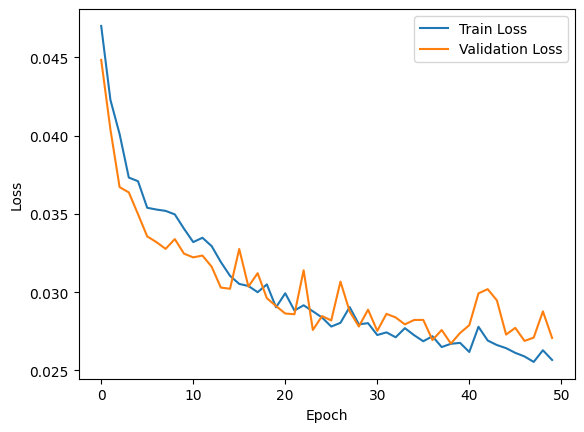

In [ ]:
epochs = 50
loss_history = []

for epoch in range(1, epochs+1):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss   = evaluate(model, val_loader, criterion, device)

    print(f"Epoch [{epoch}/{epochs}] "
          f"- Train loss: {train_loss:.4f} "
          f"- Val loss: {val_loss:.4f}")

    loss_history.append((train_loss, val_loss))

# Plot loss curve
import matplotlib.pyplot as plt

train_losses, val_losses = zip(*loss_history)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
os.makedirs("checkpoints", exist_ok=True)
torch.save(model.state_dict(), "checkpoints/attention_map_reference_model.pth")
print("Modèle sauvegardé dans 'checkpoints/attention_map_reference_model.pth'")

ðŸ’¾ ModÃ¨le sauvegardÃ© dans 'checkpoints/attention_map_reference_model.pth'


✔ Modèle chargé.


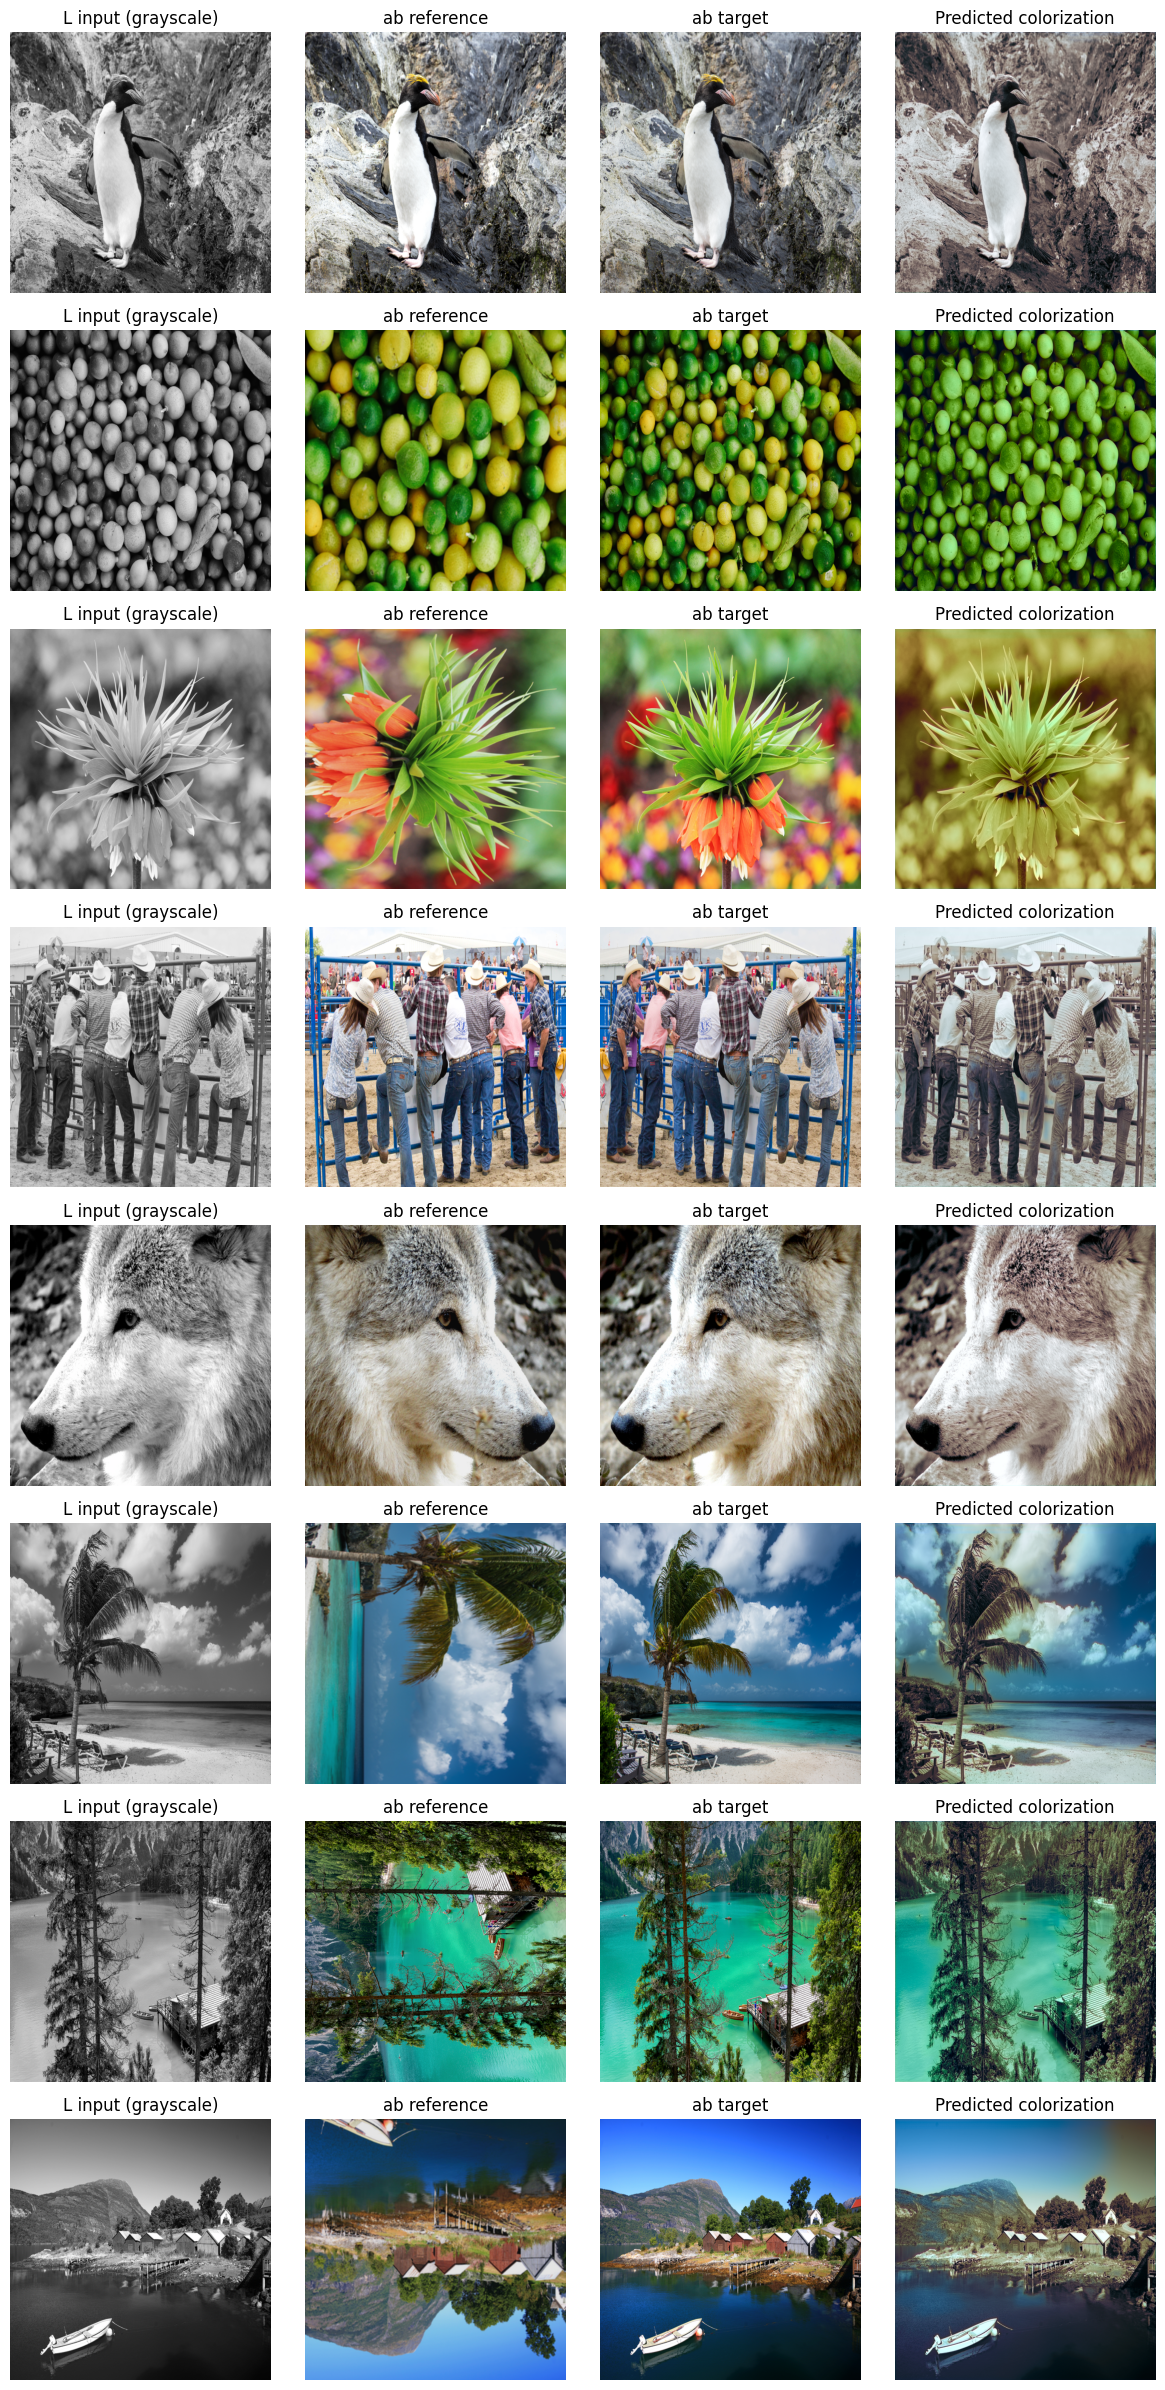

In [ ]:
from utils.data import lab_to_rgb


model.load_state_dict(torch.load("checkpoints/attention_map_reference_model.pth", map_location=device))
model.eval()

print("Modèle chargé.")
model.eval()
device = next(model.parameters()).device

n_samples = 8  # number of images to visualize
fig, axes = plt.subplots(n_samples, 4, figsize=(12, 3*n_samples))

for i in range(n_samples):
    L_src, L_ref, rgb_ref, ab_ref, ab_src, rgb_src = test_ds[i]

    # Luminance de la cible
    L_tensor = L_src.unsqueeze(0).to(device)      # 1 x 1 x H x W

    # Luminance de la référence
    RL_tensor = L_ref.unsqueeze(0).to(device)    # 1 x 1 x H x W

    # RGB référence pour VGG
    R_lab_tensor = rgb_ref.unsqueeze(0).to(device)  # 1 x 3 x H x W

    # Predict
    with torch.no_grad():
        ab_pred = model(L_tensor, RL_tensor, R_lab_tensor)[0]

    # Convert to RGB
    rgb_input = lab_to_rgb(L_src, torch.zeros_like(ab_src))
    rgb_target = lab_to_rgb(L_src, ab_src)
    rgb_pred = lab_to_rgb(L_src, ab_pred.cpu())

    # --- Convert to numpy HxWxC pour imshow ---
    def to_np_img(img):
        if torch.is_tensor(img):
            img = img.cpu().numpy()
        if img.shape[0] == 3:  # C x H x W -> H x W x C
            img = img.transpose(1, 2, 0)
        return np.clip(img, 0, 1)

    axes[i,0].imshow(to_np_img(rgb_input))
    axes[i,0].set_title("L input (grayscale)")
    axes[i,1].imshow(to_np_img(rgb_ref))
    axes[i,1].set_title("ab reference")
    axes[i,2].imshow(to_np_img(rgb_target))
    axes[i,2].set_title("ab target")
    axes[i,3].imshow(to_np_img(rgb_pred))
    axes[i,3].set_title("Predicted colorization")

    for j in range(4):
        axes[i,j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import os
import json
import torch
from torch.utils.data import DataLoader
from utils.metrics import (
    l1_metric, l2_metric, psnr_metric, ssim_metric,
    LPIPSMetric, FIDMetric
)
from utils.data import lab_to_rgb_batch


# --------------------------------------------------------
# Device
# --------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------------------------------------------
# Load data
# --------------------------------------------------------
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Metrics setup
# --------------------------------------------------------
slow_lpips = LPIPSMetric(device=device)
slow_fid   = FIDMetric(device=device)

# Aggregation
agg = {
    "L1": [],
    "L2": [],
    "PSNR": [],
    "SSIM": [],
    "LPIPS": []
}

# Create results dir
os.makedirs("experiments", exist_ok=True)

# --------------------------------------------------------
# Loop on test set
# --------------------------------------------------------
model.eval()

with torch.no_grad():
    for L, L_ref, R_lab, ab_ref, ab_gt, _ in test_loader:

        L      = L.to(device)                # B x 1 x H x W
        L_ref  = L_ref.to(device)            # B x 1 x H x W
        R_lab = R_lab.to(device)         # B x 3 x H x W
        ab_gt  = ab_gt.to(device)            # B x 2 x H x W

        # Predict
        ab_pred = model(L, L_ref, R_lab)

        # Convert to RGB for evaluation
        rgb_pred = lab_to_rgb_batch(L, ab_pred).to(device)
        rgb_gt   = lab_to_rgb_batch(L, ab_gt).to(device)

        # Fast metrics
        agg["L1"].append(l1_metric(rgb_pred, rgb_gt))
        agg["L2"].append(l2_metric(rgb_pred, rgb_gt))
        agg["PSNR"].append(psnr_metric(rgb_pred, rgb_gt))
        agg["SSIM"].append(ssim_metric(rgb_pred, rgb_gt))

        # Slow metrics
        agg["LPIPS"].append(slow_lpips(rgb_pred.float(), rgb_gt.float()))
        slow_fid.update(rgb_pred, rgb_gt)
    # --------------------------------------------------------
    # Final aggregation
    # --------------------------------------------------------
    final_metrics = {
        k: float(sum(vals) / len(vals)) for k, vals in agg.items()
    }
    
    final_metrics["FID"] = slow_fid.compute()
    
    # --------------------------------------------------------
    # Save metrics
    # --------------------------------------------------------
    out_json = os.path.join("experiments", "attention_map_model_metrics.json")
    with open(out_json, "w") as f:
        json.dump(final_metrics, f, indent=4)
    
    print("\nSaved results to:", out_json)
    print("\nFinal Metrics:")
    print(json.dumps(final_metrics, indent=4))


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/data1/aguerouani/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data1/aguerouani/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /data1/aguerouani/.venv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


/data1/aguerouani/utils/data.py:31: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  rgb = np.clip(lab2rgb(lab.astype(np.float64)), 0, 1)
/data1/aguerouani/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(
/data1/aguerouani/utils/data.py:31: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 6 negative Z values that have been clipped to zero
  rgb = np.clip(lab2rgb(lab.astype(np.float64)), 0, 1)
/data1/aguerouani/utils/data.py:31: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  rgb = np.clip(lab2rgb(lab.astype(np.float64)), 0, 1)



Saved results to: experiments/attention_map_model_metrics.json

Final Metrics:
{
    "L1": 0.04440548697091709,
    "L2": 0.005315618369931856,
    "PSNR": 23.067058844447637,
    "SSIM": 0.9060035463916147,
    "LPIPS": 0.15937213943554804,
    "FID": 87.84563446044922
}
